In [4]:
metadata = get_metadata()

for paper in metadata:
    first_paper = json.loads(paper)
    break
    
for key in first_paper:
    print(key, ':', first_paper[key])

id : 0704.0001
submitter : Pavel Nadolsky
authors : C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan
title : Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
comments : 37 pages, 15 figures; published version
journal-ref : Phys.Rev.D76:013009,2007
doi : 10.1103/PhysRevD.76.013009
report-no : ANL-HEP-PR-07-12
categories : hep-ph
license : None
abstract :   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detai

In [5]:
author = [] 
title = []
categories = []
abstract = []

n_journal_publicated = 0

for ind, paper in tqdm(enumerate(metadata)):
    paper = json.loads(paper)
    if paper['journal-ref'] != None:
        n_journal_publicated += 1      
        author.append(paper['submitter'])
        title.append(paper['title'])
        categories.append(paper['categories'])
        abstract.append(paper['abstract'])

print(f'paper publicated on journals is: {n_journal_publicated}')

2061366it [01:00, 33898.69it/s]

paper publicated on journals is: 761112


In [6]:
df = pd.DataFrame({'author':author,
                   'title':title,
                   'categories':categories, 
                   'abstract':abstract})
df.head()

,author,title,categories,abstract
0,Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...
1,Alejandro Corichi,Polymer Quantum Mechanics and its Continuum Limit,gr-qc,A rather non-standard quantum representation...
2,Damian Swift,Numerical solution of shock and ramp compressi...,cond-mat.mtrl-sci,A general formulation was developed to repre...
3,Paul Harvey,"The Spitzer c2d Survey of Large, Nearby, Inste...",astro-ph,We discuss the results from the combined IRA...
4,Christian Stahn,Fermionic superstring loop amplitudes in the p...,hep-th,The pure spinor formulation of the ten-dimen...


In [7]:
df.shape

(761112, 4)

In [8]:
papers = pd.DataFrame({
    'title': title,
    'abstract': abstract,
    'categories': categories
})

papers = papers.iloc[:20000]

papers['abstract'] = papers['abstract'].apply(lambda x: x.replace("\n",""))
papers['abstract'] = papers['abstract'].apply(lambda x: x.strip())
papers['text'] = papers['title'] + '. ' + papers['abstract']

papers['categories'] = papers['categories'].apply(lambda x: tuple(x.split()))

shortlisted_categories = papers['categories'].value_counts().reset_index(name="count").query("count > 250")["index"].tolist()
papers = papers[papers["categories"].isin(shortlisted_categories)].reset_index(drop=True)

papers = papers.sample(frac=1).reset_index(drop=True)

papers = papers.groupby('categories').head(250).reset_index(drop=True)

multi_label_encoder = MultiLabelBinarizer()
multi_label_encoder.fit(papers['categories'])
papers['categories_encoded'] = papers['categories'].apply(lambda x: multi_label_encoder.transform([x])[0])

papers = papers[["text", "categories", "categories_encoded"]]
papers.head()

,text,categories,categories_encoded
0,AdS$_5$ rotating non-Abelian black holes. We p...,"(hep-th,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,Low Mass Dimuons Produced in Relativistic Nucl...,"(hep-ph,)","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,Nonlinear Thermal Properties of Three-Terminal...,"(cond-mat.mes-hall,)","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Very High Energy Gamma-ray Radiation from the ...,"(astro-ph,)","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Image Storage in Hot Vapors. We theoretically ...,"(quant-ph,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [9]:
papers.shape

(3000, 3)

In [10]:
train, test = train_test_split(papers, test_size=0.3, stratify=papers['categories'], random_state=42)

Модель:

In [11]:
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 4,
    "num_train_epochs": 4,
}

model = MultiLabelClassificationModel('xlnet', 
                                      'xlnet-base-cased', 
                                      num_labels=len(shortlisted_categories), 
                                      args=model_args)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

In [13]:
model.train_model(train[['text', 'categories_encoded']])

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/525 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/525 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/525 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/525 [00:00<?, ?it/s]

(2100, 0.11498972341728707)

In [14]:
result, model_outputs, wrong_predictions = model.eval_model(test[['text', 'categories_encoded']])
print(result)

  0%|          | 0/900 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/113 [00:00<?, ?it/s]

{'LRAP': 0.8795013628346968, 'eval_loss': 0.10731662888969995}


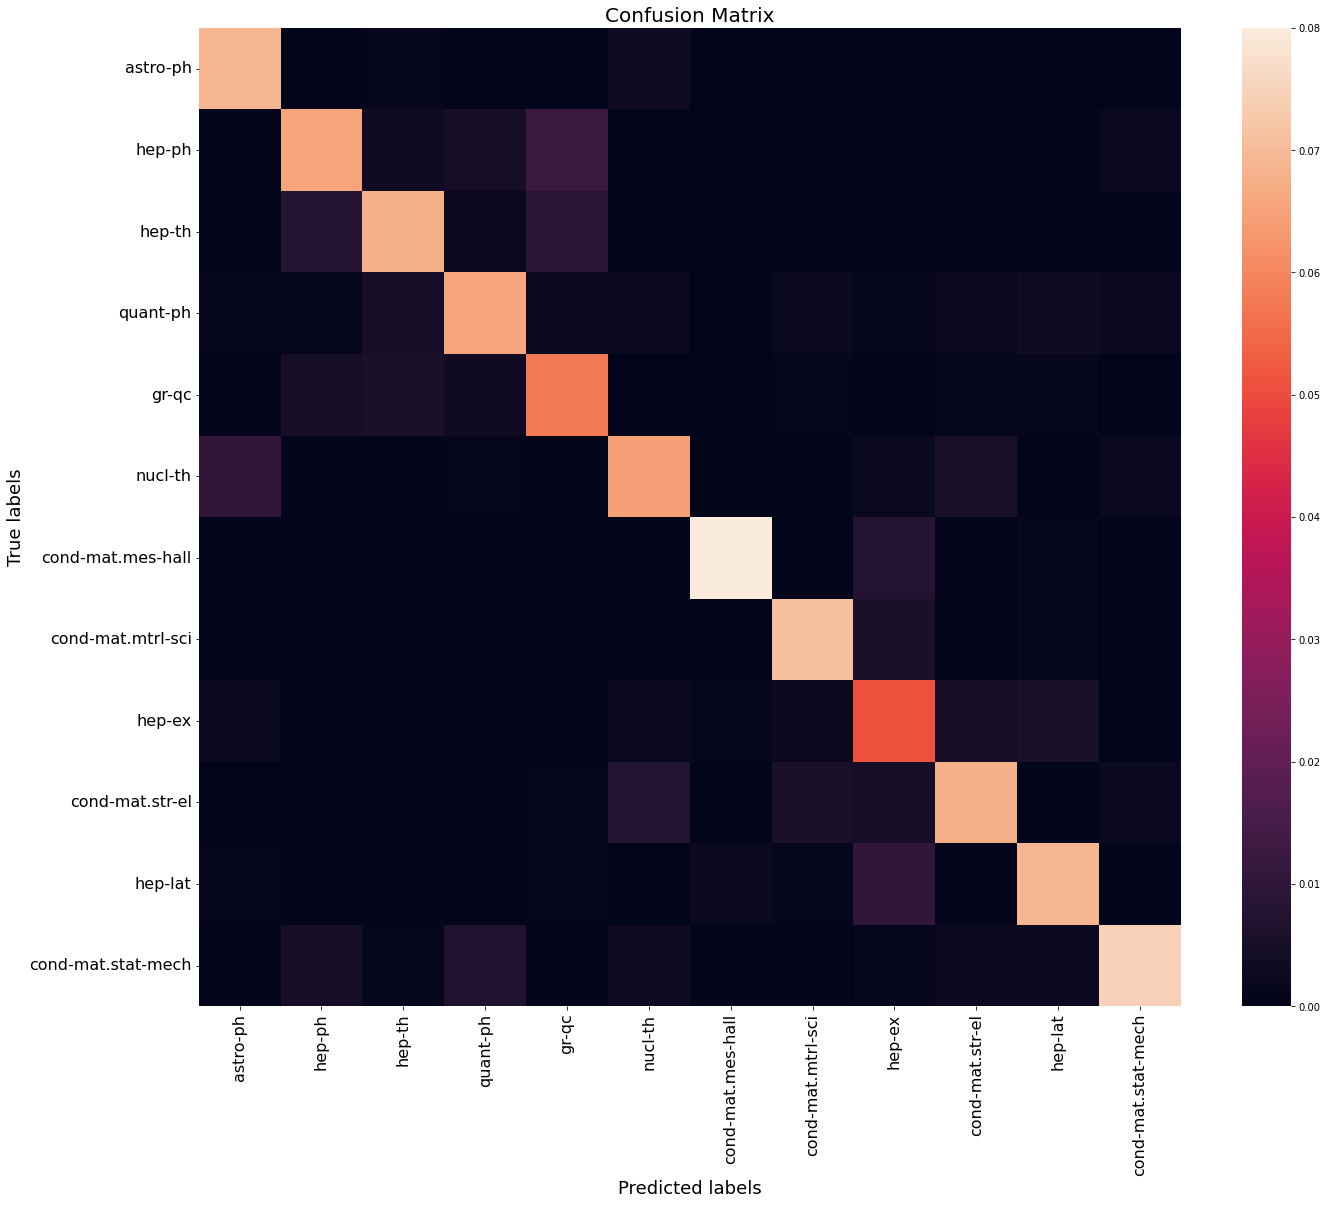

In [15]:
predicted_categories_argmax = list(map(lambda x: np.argmax(x), model_outputs))
predicted_categories_encoded = np.eye(len(shortlisted_categories))[predicted_categories_argmax]
predicted_categories = multi_label_encoder.inverse_transform(predicted_categories_encoded)

eval_gt_labels = test["categories"].tolist()

shortlisted_categories_formatted = list(map(lambda x: list(x)[0], shortlisted_categories))

plt.figure(figsize=(22,18))
cf_matrix = confusion_matrix(predicted_categories, eval_gt_labels)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix))
ax.set_xlabel('Predicted labels', fontsize=18)
ax.set_ylabel('True labels', fontsize=18)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(shortlisted_categories_formatted, rotation=90, fontsize=16)
ax.set_yticklabels(shortlisted_categories_formatted, rotation=0, fontsize=16)

plt.show()

In [16]:
category_map = {'astro-ph': 'Astrophysics',
                'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                'astro-ph.EP': 'Earth and Planetary Astrophysics',
                'astro-ph.GA': 'Astrophysics of Galaxies',
                'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
                'astro-ph.SR': 'Solar and Stellar Astrophysics',
                'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
                'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
                'cond-mat.mtrl-sci': 'Materials Science',
                'cond-mat.other': 'Other Condensed Matter',
                'cond-mat.quant-gas': 'Quantum Gases',
                'cond-mat.soft': 'Soft Condensed Matter',
                'cond-mat.stat-mech': 'Statistical Mechanics',
                'cond-mat.str-el': 'Strongly Correlated Electrons',
                'cond-mat.supr-con': 'Superconductivity',
                'cs.AI': 'Artificial Intelligence',
                'cs.AR': 'Hardware Architecture',
                'cs.CC': 'Computational Complexity',
                'cs.CE': 'Computational Engineering, Finance, and Science',
                'cs.CG': 'Computational Geometry',
                'cs.CL': 'Computation and Language',
                'cs.CR': 'Cryptography and Security',
                'cs.CV': 'Computer Vision and Pattern Recognition',
                'cs.CY': 'Computers and Society',
                'cs.DB': 'Databases',
                'cs.DC': 'Distributed, Parallel, and Cluster Computing',
                'cs.DL': 'Digital Libraries',
                'cs.DM': 'Discrete Mathematics',
                'cs.DS': 'Data Structures and Algorithms',
                'cs.ET': 'Emerging Technologies',
                'cs.FL': 'Formal Languages and Automata Theory',
                'cs.GL': 'General Literature',
                'cs.GR': 'Graphics',
                'cs.GT': 'Computer Science and Game Theory',
                'cs.HC': 'Human-Computer Interaction',
                'cs.IR': 'Information Retrieval',
                'cs.IT': 'Information Theory',
                'cs.LG': 'Machine Learning',
                'cs.LO': 'Logic in Computer Science',
                'cs.MA': 'Multiagent Systems',
                'cs.MM': 'Multimedia',
                'cs.MS': 'Mathematical Software',
                'cs.NA': 'Numerical Analysis',
                'cs.NE': 'Neural and Evolutionary Computing',
                'cs.NI': 'Networking and Internet Architecture',
                'cs.OH': 'Other Computer Science',
                'cs.OS': 'Operating Systems',
                'cs.PF': 'Performance',
                'cs.PL': 'Programming Languages',
                'cs.RO': 'Robotics',
                'cs.SC': 'Symbolic Computation',
                'cs.SD': 'Sound',
                'cs.SE': 'Software Engineering',
                'cs.SI': 'Social and Information Networks',
                'cs.SY': 'Systems and Control',
                'econ.EM': 'Econometrics',
                'eess.AS': 'Audio and Speech Processing',
                'eess.IV': 'Image and Video Processing',
                'eess.SP': 'Signal Processing',
                'gr-qc': 'General Relativity and Quantum Cosmology',
                'hep-ex': 'High Energy Physics - Experiment',
                'hep-lat': 'High Energy Physics - Lattice',
                'hep-ph': 'High Energy Physics - Phenomenology',
                'hep-th': 'High Energy Physics - Theory',
                'math.AC': 'Commutative Algebra',
                'math.AG': 'Algebraic Geometry',
                'math.AP': 'Analysis of PDEs',
                'math.AT': 'Algebraic Topology',
                'math.CA': 'Classical Analysis and ODEs',
                'math.CO': 'Combinatorics',
                'math.CT': 'Category Theory',
                'math.CV': 'Complex Variables',
                'math.DG': 'Differential Geometry',
                'math.DS': 'Dynamical Systems',
                'math.FA': 'Functional Analysis',
                'math.GM': 'General Mathematics',
                'math.GN': 'General Topology',
                'math.GR': 'Group Theory',
                'math.GT': 'Geometric Topology',
                'math.HO': 'History and Overview',
                'math.IT': 'Information Theory',
                'math.KT': 'K-Theory and Homology',
                'math.LO': 'Logic',
                'math.MG': 'Metric Geometry',
                'math.MP': 'Mathematical Physics',
                'math.NA': 'Numerical Analysis',
                'math.NT': 'Number Theory',
                'math.OA': 'Operator Algebras',
                'math.OC': 'Optimization and Control',
                'math.PR': 'Probability',
                'math.QA': 'Quantum Algebra',
                'math.RA': 'Rings and Algebras',
                'math.RT': 'Representation Theory',
                'math.SG': 'Symplectic Geometry',
                'math.SP': 'Spectral Theory',
                'math.ST': 'Statistics Theory',
                'math-ph': 'Mathematical Physics',
                'nlin.AO': 'Adaptation and Self-Organizing Systems',
                'nlin.CD': 'Chaotic Dynamics',
                'nlin.CG': 'Cellular Automata and Lattice Gases',
                'nlin.PS': 'Pattern Formation and Solitons',
                'nlin.SI': 'Exactly Solvable and Integrable Systems',
                'nucl-ex': 'Nuclear Experiment',
                'nucl-th': 'Nuclear Theory',
                'physics.acc-ph': 'Accelerator Physics',
                'physics.ao-ph': 'Atmospheric and Oceanic Physics',
                'physics.app-ph': 'Applied Physics',
                'physics.atm-clus': 'Atomic and Molecular Clusters',
                'physics.atom-ph': 'Atomic Physics',
                'physics.bio-ph': 'Biological Physics',
                'physics.chem-ph': 'Chemical Physics',
                'physics.class-ph': 'Classical Physics',
                'physics.comp-ph': 'Computational Physics',
                'physics.data-an': 'Data Analysis, Statistics and Probability',
                'physics.ed-ph': 'Physics Education',
                'physics.flu-dyn': 'Fluid Dynamics',
                'physics.gen-ph': 'General Physics',
                'physics.geo-ph': 'Geophysics',
                'physics.hist-ph': 'History and Philosophy of Physics',
                'physics.ins-det': 'Instrumentation and Detectors',
                'physics.med-ph': 'Medical Physics',
                'physics.optics': 'Optics',
                'physics.plasm-ph': 'Plasma Physics',
                'physics.pop-ph': 'Popular Physics',
                'physics.soc-ph': 'Physics and Society',
                'physics.space-ph': 'Space Physics',
                'q-bio.BM': 'Biomolecules',
                'q-bio.CB': 'Cell Behavior',
                'q-bio.GN': 'Genomics',
                'q-bio.MN': 'Molecular Networks',
                'q-bio.NC': 'Neurons and Cognition',
                'q-bio.OT': 'Other Quantitative Biology',
                'q-bio.PE': 'Populations and Evolution',
                'q-bio.QM': 'Quantitative Methods',
                'q-bio.SC': 'Subcellular Processes',
                'q-bio.TO': 'Tissues and Organs',
                'q-fin.CP': 'Computational Finance',
                'q-fin.EC': 'Economics',
                'q-fin.GN': 'General Finance',
                'q-fin.MF': 'Mathematical Finance',
                'q-fin.PM': 'Portfolio Management',
                'q-fin.PR': 'Pricing of Securities',
                'q-fin.RM': 'Risk Management',
                'q-fin.ST': 'Statistical Finance',
                'q-fin.TR': 'Trading and Market Microstructure',
                'quant-ph': 'Quantum Physics',
                'stat.AP': 'Applications',
                'stat.CO': 'Computation',
                'stat.ME': 'Methodology',
                'stat.ML': 'Machine Learning',
                'stat.OT': 'Other Statistics',
                'stat.TH': 'Statistics Theory'}

In [17]:
for _ in range(5):

    random_idx = random.randint(0, len(test)-1)
    text = test.iloc[random_idx]['text']
    true_categories = test.iloc[random_idx]['categories']

    predicted_categories_encoded, raw_outputs = model.predict([text])
    predicted_categories_encoded = np.array(predicted_categories_encoded)
    predicted_categories_encoded[0][np.argmax(raw_outputs[0])] = 1
    predicted_categories = multi_label_encoder.inverse_transform(predicted_categories_encoded)[0]

    print(f'True Categories:'.ljust(21,' '), f'{true_categories} - {category_map[true_categories[0]]}\n')
    print(f'Predicted Categories: {predicted_categories} - {category_map[predicted_categories[0]]}\n')
    print(f'Abstract: {text}\n\n')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('cond-mat.stat-mech',) - Statistical Mechanics

Predicted Categories: ('cond-mat.stat-mech',) - Statistical Mechanics

Abstract: Hamiltonian and Brownian systems with long-range interactions: III. The
  BBGKY hierarchy for spatially inhomogeneous systems. We study the growth of correlations in systems with weak long-rangeinteractions. Starting from the BBGKY hierarchy, we determine the evolution ofthe two-body correlation function by using an expansion of the solutions of thehierarchy in powers of 1/N in a proper thermodynamic limit $N\to +\infty$.These correlations are responsible for the ``collisional'' evolution of thesystem beyond the Vlasov regime due to finite $N$ effects. We obtain a generalkinetic equation that can be applied to spatially inhomogeneous systems andthat takes into account memory effects. These peculiarities are specific tosystems with unshielded long-range interactions. For spatially homogeneoussystems with short memory time like plasmas, w

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('nucl-th',) - Nuclear Theory

Predicted Categories: ('nucl-th',) - Nuclear Theory

Abstract: Multiplicity fluctuations in relativistic nuclear collisions. Multiplicity distributions of hadrons produced in central nucleus-nucleuscollisions are studied within the hadron-resonance gas model in the largevolume limit. In the canonical ensemble conservation of three charges (baryonnumber, electric charge, and strangeness) is enforced. In addition, in themicro-canonical ensemble energy conservation is included. An analytical methodis used to account for resonance decays. Multiplicity distributions and scaledvariances for negatively charged hadrons are presented along the chemicalfreeze-out line of central Pb+Pb (Au+Au) collisions from SIS to LHC energies.Predictions obtained within different statistical ensembles are compared withpreliminary NA49 experimental results on central Pb+Pb collisions in the SPSenergy range. The measured fluctuations are significantly narrower

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('hep-ph',) - High Energy Physics - Phenomenology

Predicted Categories: ('hep-ph',) - High Energy Physics - Phenomenology

Abstract: Spectra, triple and quartic gauge couplings in a Higgsless model. Spectra, triple and quartic gauge couplings of the Higgsless model with gaugegroup $SU(2)_L\times SU(2)_R\times U(1)_{B-L}$ defined in warped space areexplored with numerical method. We extend the equation of motions, boundaryconditions and formalism of multi-gauge-boson vertices to the Hirn-Sanzscenario. By assuming the ideally delocalized fermion profile, we study thespectra of vector bosons as well as the triple and quartic gauge couplingsamong vector bosons. It is found that mass spectra can be greatly modified bythe parameters of QCD power corrections. Meanwhile, the triple and quarticgauge couplings can deviate from the values of the standard model to at least$\pm 10%$ and can saturate the LEP2 bounds. We find the triple gauge couplingsof $Z{\bar W}W$ can be $ 5

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('cond-mat.mes-hall',) - Mesoscale and Nanoscale Physics

Predicted Categories: ('cond-mat.mes-hall',) - Mesoscale and Nanoscale Physics

Abstract: Bipartite entanglement entropy in fractional quantum Hall states. We present a detailed analysis of bipartite entanglement entropies infractional quantum Hall (FQH) states, considering both abelian (Laughlin) andnon-abelian (Moore-Read) states. We derive upper bounds for the entanglementbetween two subsets of the particles making up the state. We also consider theentanglement between spatial regions supporting a FQH state. Using the latter,we show how the so-called topological entanglement entropy of a FQH state canbe extracted from wavefunctions for a limited number of particles.




  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('cond-mat.mtrl-sci',) - Materials Science

Predicted Categories: ('cond-mat.mtrl-sci',) - Materials Science

Abstract: Effect of internal friction on transformation twin dynamics in
  SrxBa1-xSnO3 perovskite. The dynamics of transformation twins in SrxBa1-xSnO3 (x=0.6,0.8) perovskitehas been studied by dynamical mechanical analysis in three-point bend geometry.This material undergoes phase transitions from orthorhombic to tetragonal andcubic structures on heating. The mechanical loss signatures of thetransformation twins include relaxation and frequency-independent peaks in theorthorhombic and tetragonal phases, with no observed energy dissipation in thecubic phase. The macroscopic shape, orientation and relative displacements oftwin walls have been calculated from bending and anisotropy energies. Themechanical loss angle and distribution of relaxation time are discussed in termof bending modes of domain walls.


